In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', False)
pd.set_option('display.max_colwidth', None)

In [4]:
data = pd.read_csv('ADA_1sec_adtl.csv').set_index('system_time')
data.index = pd.to_datetime(data.index)

In [25]:
data['ask_fill']

system_time
2021-04-07 11:33:00.055697+00:00    0
2021-04-07 11:33:01.055697+00:00    0
2021-04-07 11:33:02.055697+00:00    0
2021-04-07 11:33:03.055697+00:00    0
2021-04-07 11:33:04.055697+00:00    0
                                   ..
2021-04-19 09:49:37.442103+00:00    0
2021-04-19 09:49:38.442103+00:00    0
2021-04-19 09:49:39.442103+00:00    0
2021-04-19 09:49:40.442103+00:00    0
2021-04-19 09:49:41.442103+00:00    0
Name: ask_fill, Length: 1030533, dtype: int64

In [5]:
data.columns

Index(['midpoint', 'spread', 'buys', 'sells', 'bids_distance_0',
       'bids_distance_1', 'bids_distance_2', 'bids_distance_3',
       'bids_distance_4', 'bids_distance_5',
       ...
       'asks_patience', 'spread_rm', 'spread_rstd', 'time_sin', 'time_cos',
       'signal_flow_mom', 'exec_imb', 'signal_exec_imb', 'long_imb_exploit',
       'short_imb_exploit'],
      dtype='object', length=194)

In [6]:
full_column_list = data.columns.to_list()
print(full_column_list)


['midpoint', 'spread', 'buys', 'sells', 'bids_distance_0', 'bids_distance_1', 'bids_distance_2', 'bids_distance_3', 'bids_distance_4', 'bids_distance_5', 'bids_distance_6', 'bids_distance_7', 'bids_distance_8', 'bids_distance_9', 'bids_distance_10', 'bids_distance_11', 'bids_distance_12', 'bids_distance_13', 'bids_distance_14', 'bids_notional_0', 'bids_notional_1', 'bids_notional_2', 'bids_notional_3', 'bids_notional_4', 'bids_notional_5', 'bids_notional_6', 'bids_notional_7', 'bids_notional_8', 'bids_notional_9', 'bids_notional_10', 'bids_notional_11', 'bids_notional_12', 'bids_notional_13', 'bids_notional_14', 'bids_cancel_notional_0', 'bids_cancel_notional_1', 'bids_cancel_notional_2', 'bids_cancel_notional_3', 'bids_cancel_notional_4', 'bids_cancel_notional_5', 'bids_cancel_notional_6', 'bids_cancel_notional_7', 'bids_cancel_notional_8', 'bids_cancel_notional_9', 'bids_cancel_notional_10', 'bids_cancel_notional_11', 'bids_cancel_notional_12', 'bids_cancel_notional_13', 'bids_cancel

In [7]:
volume_bids = pd.DataFrame()
volume_asks = pd.DataFrame()
for x in data.columns:
    if 'market' in x:
        if 'bid' in x:
            volume_bids[x] = data[x].copy()
        elif 'ask' in x:
            volume_asks[x] = data[x].copy()

In [8]:
data['midpoint'] /= 1000

In [9]:
# Filter rows where 'bids_market_notional_0' is less than the row-wise sum of all columns in 'volume_bids'
#if only the level 0 exceeds total, there's a problem
condition = volume_bids['bids_market_notional_0'] < volume_bids.sum(axis=1)
filtered_bids = volume_bids[condition]

# Compute the cumulative sum and normalize by the row-wise sum
normalized_bids = filtered_bids.cumsum(axis=1).div(filtered_bids.sum(axis=1), axis=0)

normalized_bids = normalized_bids.stack() #multiIndex
normalized_bids = normalized_bids[normalized_bids>=1].reset_index().groupby(['system_time' , 0]).first()
normalized_bids.reset_index(inplace=True)
normalized_bids['level_2'] = normalized_bids['level_1'].apply(lambda x: x.replace('market_notional', 'price'))
#normalized_bids

In [10]:

condition = volume_asks['asks_market_notional_0'] < volume_asks.sum(axis=1)

filtered_asks = volume_asks[condition]

normalized_asks = filtered_asks.cumsum(axis=1).div(filtered_asks.sum(axis=1), axis=0)

normalized_asks = normalized_asks.stack()
normalized_asks = normalized_asks[normalized_asks>=1].reset_index().groupby(['system_time' , 0]).first()
normalized_asks.reset_index(inplace=True)
normalized_asks['level_2'] = normalized_asks['level_1'].apply(lambda x: x.replace('market_notional', 'price'))


In [11]:
# Initialize empty DataFrames for storing bid and ask prices
prices_bids = pd.DataFrame()
prices_asks = pd.DataFrame()
#compute actual bids and prices
# Loop through the columns to calculate adjusted prices for bids and asks
for x in data.columns:
    if 'distance' in x:  # Look for columns with 'distance' in their names
        if 'bids' in x:  # For bid distances
            prices_bids[x.replace('distance', 'price')] = data['midpoint'] * (1 + data[x])
        else:  # For ask distances
            prices_asks[x.replace('distance', 'price')] = data['midpoint'] * (1 + data[x])


In [12]:
# Compute delta prices for bids and asks
#pick out executed price per second;
#now we have price for every second
delta_price_bids = pd.concat([prices_bids.stack(), normalized_bids.set_index(['system_time' , 'level_2'])[0]], axis=1
).dropna()
delta_price_bids = delta_price_bids.reset_index().iloc[:, [0, 2]]

In [13]:
delta_price_asks = pd.concat([prices_asks.stack(), normalized_asks.set_index(['system_time' , 'level_2'])[0]], axis=1
).dropna()
delta_price_asks = delta_price_asks.reset_index().iloc[:, [0, 2]]

In [14]:
# Create DataFrame for delta prices for bids
delta_price_bids = pd.DataFrame(
    delta_price_bids.set_index('system_time').values.T[0] -
    data.loc[delta_price_bids['system_time'],'midpoint']
)
# Create DataFrame for delta prices for asks
delta_price_asks = pd.DataFrame(
    delta_price_asks.set_index('system_time').values.T[0] -
    data.loc[delta_price_asks['system_time'] , 'midpoint']
)

In [15]:
data.head()

,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,bids_distance_5,bids_distance_6,bids_distance_7,bids_distance_8,bids_distance_9,bids_distance_10,bids_distance_11,bids_distance_12,bids_distance_13,bids_distance_14,bids_notional_0,bids_notional_1,bids_notional_2,bids_notional_3,bids_notional_4,bids_notional_5,bids_notional_6,bids_notional_7,bids_notional_8,bids_notional_9,bids_notional_10,bids_notional_11,bids_notional_12,bids_notional_13,bids_notional_14,bids_cancel_notional_0,bids_cancel_notional_1,bids_cancel_notional_2,bids_cancel_notional_3,bids_cancel_notional_4,bids_cancel_notional_5,...,avg_depth_bid_top3,depth_bid_0_5,depth_ask_0_5,imb_0,imb_1,imb_2,imb_3,imb_4,imb_5,imb_6,imb_7,imb_8,imb_9,imb_10,imb_11,imb_12,imb_13,imb_14,vw_dist_bid,flow_net_mkt,OFI,flow_net_mkt_sma_10,level_bids,level_asks,exec_impact_bid,exec_impact_ask,ret_1s,vol_30s,mom_5s,bids_patience,asks_patience,spread_rm,spread_rstd,time_sin,time_cos,signal_flow_mom,exec_imb,signal_exec_imb,long_imb_exploit,short_imb_exploit
system_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-07 11:33:00.055697+00:00,0.001171,0.0015,0.000000,0.0000,-0.000641,-0.000726,-0.000811,-0.000897,-0.001068,-0.001153,-0.001239,-0.001409,-0.001495,-0.001580,-0.001666,-0.001751,-0.001836,-0.001922,-0.002007,177076.125000,11899.009766,2691.939941,805.919983,1561.260010,550.969971,981.169983,5571.500000,4003.320068,58.450001,550.969971,143.169998,804.549988,2473.290039,11053.080078,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,5779.981649,194585.224670,53996.850464,0.972594,0.597002,-0.773672,0.028103,-0.886163,-0.189005,-0.847768,0.809531,-0.347660,-0.983542,-0.815252,-0.850022,-0.108310,0.163682,0.348213,-0.000781,0.000000,123116.444584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,1.000000,-1,NaN,-1,False,False
2021-04-07 11:33:01.055697+00:00,0.001170,0.0001,684.618694,74178.0000,-0.000043,-0.000128,-0.000214,-0.000470,-0.000641,-0.000812,-0.000897,-0.000983,-0.001068,-0.001154,-0.001239,-0.001325,-0.001410,-0.001496,-0.001581,102898.132812,11899.009766,617.400024,755.469971,806.820007,982.169983,4003.320068,864.989990,1998.449951,143.169998,596.750000,393.339996,11053.080078,6.390000,758.750000,0.0,2621.469971,5883.810059,1521.380005,0.000000,0.0,...,6232.291779,117959.002563,31230.280762,0.943575,-0.266587,-0.268925,-0.737725,-0.000898,0.097047,0.663939,0.242454,-0.519043,-0.989472,-0.861049,-0.931561,0.899231,-0.997524,-0.805532,-0.000236,73884.320007,-31168.011658,NaN,NaN,NaN,NaN,NaN,-0.000598,NaN,NaN,0.500937,0.331486,NaN,NaN,0.104528,0.994522,-1,NaN,-1,False,False
2021-04-07 11:33:02.055697+00:00,0.001170,0.0009,1280.056786,1835.7300,-0.000384,-0.000470,-0.000555,-0.000641,-0.000812,-0.000983,-0.001153,-0.001239,-0.001324,-0.001495,-0.001581,-0.001666,-0.001751,-0.001837,-0.001922,101062.398438,11899.009766,70.699997,546.719971,755.469971,806.820007,806.679993,4003.320068,864.989990,143.169998,939.229980,393.339996,11053.080078,2004.729980,758.760010,0.0,0.000000,546.690002,0.000000,0.000000,0.0,...,12931.691874,115141.118149,60694.831787,0.942749,-0.266626,-0.876217,-0.418887,-0.802579,-0.943713,-0.922648,0.664202,-0.804689,-0.974535,-0.691739,-0.894234,-0.639238,0.334383,-0.398954,-0.000589,1643.699982,-73530.831863,NaN,NaN,NaN,NaN,NaN,0.000342,NaN,NaN,0.248840,0.193562,NaN,NaN,0.207912,0.978148,-1,NaN,-1,False,False
2021-04-07 11:33:03.055697+00:00,0.001170,0.0001,5.487769,1111.9329,-0.000043,-0.000128,-0.000214,-0.000470,-0.000556,-0.000726,-0.000897,-0.000983,-0.001068,-0.001154,-0.001239,-0.001325,-0.001410,-0.001496,-0.001667,100242.968750,11899.009766,70.699997,755.469971,546.650024,806.750000,4809.930176,58.450001,806.469971,143.169998,6514.640137,393.339996,11053.080078,2004.729980,758.760010,0.0,0.000000,805.989990,805.789978,1356.689941,0.0,...,13481.688517,114321.548508,31179.830322,0.971905,-0.266706,-0.800910,-0.033122,-0.436420,-0.

In [16]:
data['bid_fill'] = data['exec_impact_bid'].notnull().astype(int)
data['ask_fill'] = data['exec_impact_ask'].notnull().astype(int)

In [17]:
counts = pd.DataFrame({
    'bid_fills': data['bid_fill'].resample('1S').sum(),
    'ask_fills': data['ask_fill'].resample('1S').sum()
})

C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\3288791594.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  'bid_fills': data['bid_fill'].resample('1S').sum(),
C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\3288791594.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  'ask_fills': data['ask_fill'].resample('1S').sum()


In [18]:
features = data[[
    'spread', 
    'depth_bid_0_5', 'depth_ask_0_5',
    'imb_0', 'imb_1', 'imb_2',
    'vol_30s',
    'signal_flow_mom'
]]

In [1]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np


In [19]:
final_data_with_lags = pd.read_csv('final_data_with_lags.csv')

In [22]:
import numpy as np
import pandas as pd

# --- 0) Floor to seconds and build a dense 1s grid of counts ---
counts_sec = (
    counts.copy()
    .set_index(counts.index.floor('S'))
    .groupby(level=0)[['bid_fills','ask_fills']].sum()
    .asfreq('S', fill_value=0)
)

# --- 1) Global baseline μ₀ (per-second) for the prior ---
total_secs = len(counts_sec)
mu0_bid = counts_sec['bid_fills'].sum() / max(total_secs, 1)
mu0_ask = counts_sec['ask_fills'].sum() / max(total_secs, 1)

T0 = 120  # "prior strength" in seconds (tune: 60–300 works well)
alpha_bid, alpha_ask = mu0_bid * T0, mu0_ask * T0
beta = T0

# --- 2) Rolling (causal) Gamma–Poisson posterior mean ---
W = 120  # rolling window in seconds (tune)
ones = pd.Series(1.0, index=counts_sec.index)

mass = ones.rolling(W, min_periods=1).sum()
nbid = counts_sec['bid_fills'].rolling(W, min_periods=1).sum()
nask = counts_sec['ask_fills'].rolling(W, min_periods=1).sum()

lambda_bid = (alpha_bid + nbid) / (beta + mass)
lambda_ask = (alpha_ask + nask) / (beta + mass)

data_sec = counts_sec.copy()
data_sec['lambda_bid'] = lambda_bid.clip(lower=1e-8)
data_sec['lambda_ask'] = lambda_ask.clip(lower=1e-8)


C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\1662614878.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .set_index(counts.index.floor('S'))
C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\1662614878.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .asfreq('S', fill_value=0)


In [23]:
data_sec

,bid_fills,ask_fills,lambda_bid,lambda_ask
system_time,,,,
2021-04-07 11:33:00+00:00,0,0,0.023743,0.087553
2021-04-07 11:33:01+00:00,0,0,0.023548,0.086835
2021-04-07 11:33:02+00:00,0,0,0.023356,0.086129
2021-04-07 11:33:03+00:00,0,0,0.023168,0.085435
2021-04-07 11:33:04+00:00,0,0,0.022983,0.084751
...,...,...,...,...
2021-04-19 09:49:37+00:00,0,0,0.011970,0.052475
2021-04-19 09:49:38+00:00,0,0,0.011970,0.052475
2021-04-19 09:49:39+00:00,0,0,0.011970,0.052475


In [49]:
data_AS = pd.DataFrame(index=data.index)
prices = pd.DataFrame()

# Calculate adjusted prices
for x in data.columns:
    if 'distance' in x:
        prices[x.replace('distance', 'price')] = data['midpoint'] * (1 + data[x])

# Create a data frame with the required columns
data_AS[['midpoint', 'spread', 'buys', 'sells']] = data[['midpoint', 'spread', 'buys', 'sells']]
data_AS['farthest_bid'] = prices['bids_price_0']
data_AS['farthest_ask'] = prices['asks_price_0']

data_AS.loc[delta_price_asks.index, 'farthest_ask'] = delta_price_asks.iloc[:,0].values +data_AS.loc[delta_price_asks.index, 'midpoint']
data_AS.loc[delta_price_bids.index, 'farthest_bid'] = delta_price_bids.iloc[:,0].values +data_AS.loc[delta_price_bids.index, 'midpoint']




In [27]:
((1+data['bids_distance_0']) * data['midpoint'])[0]

C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\331127772.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ((1+data['bids_distance_0']) * data['midpoint'])[0]


np.float64(0.0011699999999817518)

In [28]:
train = pd.DataFrame()

for x in data.columns:
    if 'distance' in x:  # Look for columns with 'distance' in their names

      train[x.replace('distance', 'price')] = data['midpoint'] * (1 + data[x])
train['midpoint'] = data['midpoint']

In [29]:
actual_data = data.copy()
data = actual_data.copy()
#what does this do

In [30]:
import pandas as pd
import numpy as np

# Load the uploaded CSV file

# Function to calculate RSI
def calculate_rsi(data, column, window=14):
    delta = data[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI for the 'midpoint' column
data['RSI'] = calculate_rsi(data, 'midpoint')

# Scale bid/ask distances by midpoint
for i in range(10):
    data[f"asks_distance_{i}"] = data[f"asks_distance_{i}"] * data['midpoint']
    data[f"bids_distance_{i}"] = data[f"bids_distance_{i}"] * data['midpoint']

# Calculate Log Return
data['log_return'] = np.log(data['midpoint']).diff()

# Calculate Moving Average Return (window=5 as an example)
data['moving_avg_return'] = data['log_return'].rolling(window=5).mean()

# Calculate MACD components (12, 26, 9 periods)
short_ema = data['log_return'].ewm(span=10, adjust=False).mean()
long_ema = data['log_return'].ewm(span=50, adjust=False).mean()
data['macd'] = short_ema - long_ema * 100000
data['macd_signal'] = data['macd'].ewm(span=9, adjust=False).mean()





# Select relevant columns for the final dataset
selected_columns = ['midpoint', 'spread', 'buys', 'sells']
for i in range(3):
    selected_columns.append(f"bids_distance_{i}")
    selected_columns.append(f"asks_distance_{i}")

# Subset the data for selected features
final_data = data[selected_columns + [
    'RSI', 'log_return', 'moving_avg_return', 'macd', 'macd_signal'
]]



In [31]:
# Function to create lagged features
def create_lagged_features(data, lags=3, bid_ask_depth=3):
    """
    Add lagged features for bid/ask prices and returns to the dataset and define the next log return as the target.

    Parameters:
    - data: The DataFrame containing features.
    - lags: Number of lags for returns.
    - bid_ask_depth: Depth of bid/ask prices to lag.

    Returns:
    - DataFrame with lagged features added and next log return as the target.
    """
    lagged_features = {}

    # Create lagged features for bid/ask prices up to specified depth
    for i in range(bid_ask_depth):
        for lag in range(1, lags + 1):
            lagged_features[f'bids_distance_{i}_lag_{lag}'] = data[f'bids_distance_{i}'].shift(lag)
            lagged_features[f'asks_distance_{i}_lag_{lag}'] = data[f'asks_distance_{i}'].shift(lag)

    # Create lagged features for returns
    for lag in range(1, lags + 1):
        lagged_features[f'log_return_lag_{lag}'] = data['log_return'].shift(lag)

    # Add the next log return as the target
    data['next_log_return'] = data['log_return'].shift(-1)

    # Concatenate lagged features into the original DataFrame
    lagged_features_df = pd.concat(lagged_features, axis=1)
    data = pd.concat([data, lagged_features_df], axis=1)

    # Drop rows with NaN values due to lagging and target shifting
    data.dropna(inplace=True)

    return data


# Apply feature engineering
final_data_with_lags = create_lagged_features(final_data, lags=3, bid_ask_depth=3)


C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\3711646771.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_log_return'] = data['log_return'].shift(-1)


In [32]:
final_data_with_lags = final_data_with_lags.dropna()

In [33]:
final_data_with_lags.to_csv('final_data_with_lags.csv')

In [27]:
final_data_with_lags = pd.read_csv('final_data_with_lags.csv')

[0]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[1]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[2]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[3]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[4]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[5]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[6]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[7]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[8]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[9]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[10]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[11]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[12]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[13]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[14]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[15]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[16]	validation_0-rmse:0.00019	validation_1-rmse:0.00040
[17]	validation_0-rmse:0.00019	validation

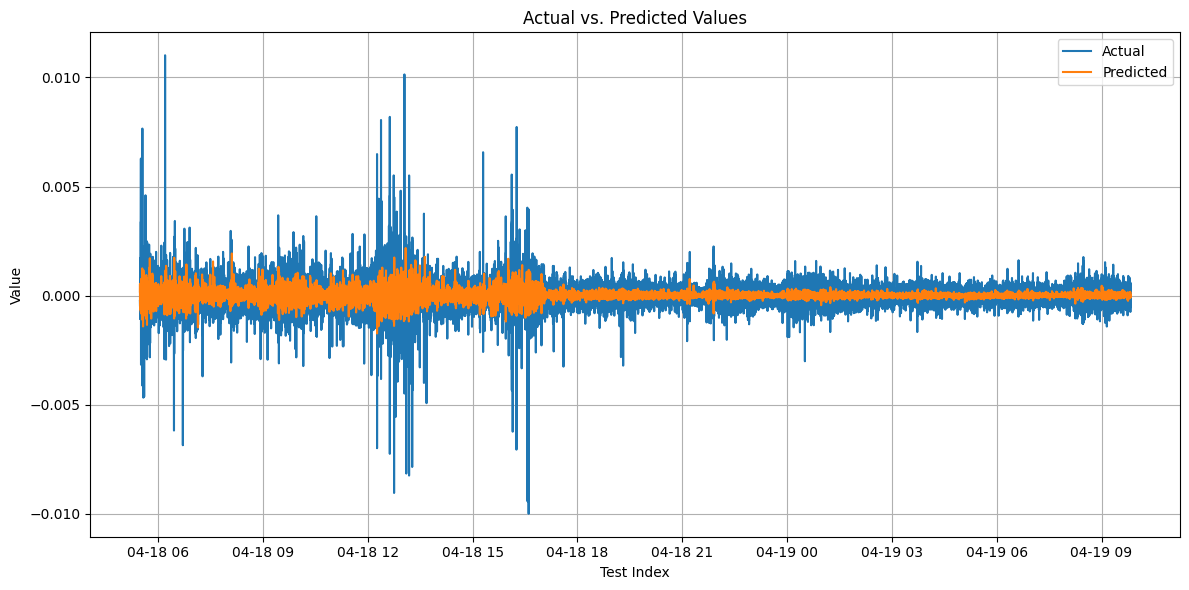

In [34]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define target variable and features
target = final_data_with_lags['next_log_return']
features = final_data_with_lags.drop(columns=['next_log_return'])

# Split data into train, validation, and test sets
n = len(features)
train_end = int(n * 0.8)  # 80% for training
val_end = int(n * 0.9)    # Next 10% for validation
test_end = n              # Final 10% for testing

X_train, y_train = features.iloc[:train_end], target.iloc[:train_end]
X_val, y_val = features.iloc[train_end:val_end], target.iloc[train_end:val_end]
X_test, y_test = features.iloc[val_end:test_end], target.iloc[val_end:test_end]

# Train the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='rmse'  # Specify the evaluation metric here
)

# Fit the model with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

# Evaluate the model on the test set
y_test_pred = xgb_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Display evaluation metrics
print(f"Test Mean Squared Error (MSE): {mse_test}")
print(f"Test Mean Absolute Error (MAE): {mae_test}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_test_pred, label='Predicted')
plt.xlabel('Test Index')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
#Plots of convergence of MSE and MAE
'''
plt.subplot(1, 2, 2)
plt.plot(y_test.index, progressive mae_test, label='MAE Convergence')
plt.plot(y_test.index, progressive mse_test, label = 'MSE Convergence')

'''
plt.tight_layout()
plt.grid(True)
plt.show()


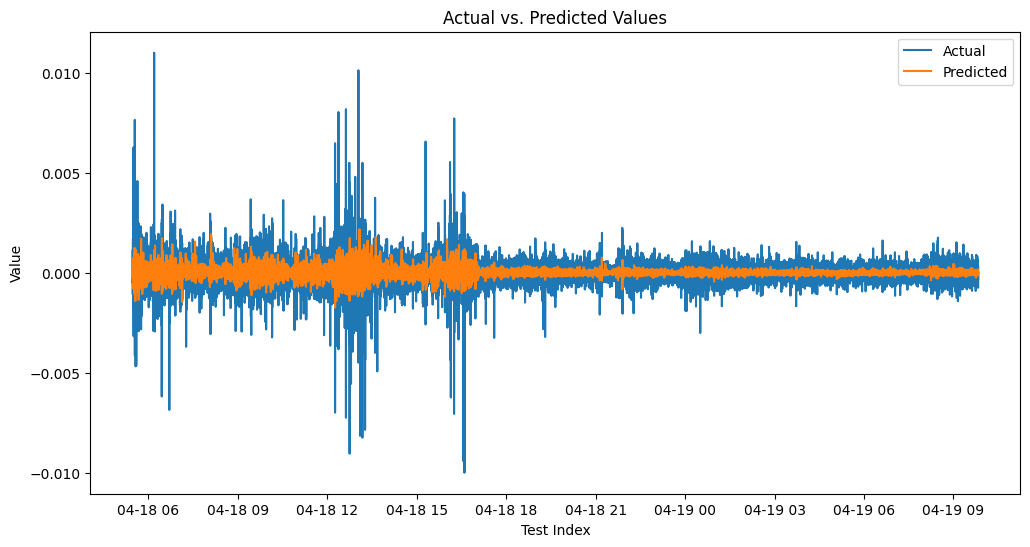

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_test_pred, label='Predicted')
plt.xlabel('Test Index')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
#Plots of convergence of MSE and MAE
'''
plt.subplot(1, 2, 2)
plt.plot(y_test.index, progressive mae_test, label='MAE Convergence')
plt.plot(y_test.index, progressive mse_test, label = 'MSE Convergence')

'''

plt.show()

In [36]:
y_val_pred = xgb_model.predict(X_val)
# Calculate the correlation between the true and predicted values
correlation = np.corrcoef(y_val, y_val_pred)# Extract the correlation coefficient

correlation[0]


array([1.        , 0.10674705])

In [37]:
signal = pd.DataFrame(y_test_pred , columns=['signal'] , index=y_test.index)

In [38]:
start_idx = np.random.randint(0, len(signal) -3*3600 )
new_signal = signal.iloc[start_idx :3600*3+start_idx, :]
indices = new_signal.index

In [39]:
data_sec['lambda_ask']

system_time
2021-04-07 11:33:00+00:00    0.087553
2021-04-07 11:33:01+00:00    0.086835
2021-04-07 11:33:02+00:00    0.086129
2021-04-07 11:33:03+00:00    0.085435
2021-04-07 11:33:04+00:00    0.084751
                               ...   
2021-04-19 09:49:37+00:00    0.052475
2021-04-19 09:49:38+00:00    0.052475
2021-04-19 09:49:39+00:00    0.052475
2021-04-19 09:49:40+00:00    0.052475
2021-04-19 09:49:41+00:00    0.052475
Freq: s, Name: lambda_ask, Length: 1030602, dtype: float64

In [40]:
data_sec[['lambda_bid','lambda_ask']].head()

,lambda_bid,lambda_ask
system_time,,
2021-04-07 11:33:00+00:00,0.023743,0.087553
2021-04-07 11:33:01+00:00,0.023548,0.086835
2021-04-07 11:33:02+00:00,0.023356,0.086129
2021-04-07 11:33:03+00:00,0.023168,0.085435
2021-04-07 11:33:04+00:00,0.022983,0.084751


In [50]:
data_AS

,midpoint,spread,buys,sells,farthest_bid,farthest_ask
system_time,,,,,,
2021-04-07 11:33:00.055697+00:00,0.001171,0.0015,0.000000,0.00000,0.001171,0.001171
2021-04-07 11:33:01.055697+00:00,0.001170,0.0001,684.618694,74178.00000,0.001170,0.001170
2021-04-07 11:33:02.055697+00:00,0.001170,0.0009,1280.056786,1835.73000,0.001170,0.001170
2021-04-07 11:33:03.055697+00:00,0.001170,0.0001,5.487769,1111.93290,0.001170,0.001170
2021-04-07 11:33:04.055697+00:00,0.001170,0.0001,683.701131,712.89270,0.001170,0.001170
...,...,...,...,...,...,...
2021-04-19 09:49:37.442103+00:00,0.001271,0.0001,2.682021,1.51249,0.001271,0.001271
2021-04-19 09:49:38.442103+00:00,0.001271,0.0001,13.397394,10.16800,0.001271,0.001271
2021-04-19 09:49:39.442103+00:00,0.001271,0.0004,0.000000,1.02951,0.001271,0.001271


In [51]:
data_sec[['lambda_bid','lambda_ask']].head()


,lambda_bid,lambda_ask
system_time,,
2021-04-07 11:33:00+00:00,0.023743,0.087553
2021-04-07 11:33:01+00:00,0.023548,0.086835
2021-04-07 11:33:02+00:00,0.023356,0.086129
2021-04-07 11:33:03+00:00,0.023168,0.085435
2021-04-07 11:33:04+00:00,0.022983,0.084751


In [52]:
data_sec.index

DatetimeIndex(['2021-04-07 11:33:00+00:00', '2021-04-07 11:33:01+00:00',
               '2021-04-07 11:33:02+00:00', '2021-04-07 11:33:03+00:00',
               '2021-04-07 11:33:04+00:00', '2021-04-07 11:33:05+00:00',
               '2021-04-07 11:33:06+00:00', '2021-04-07 11:33:07+00:00',
               '2021-04-07 11:33:08+00:00', '2021-04-07 11:33:09+00:00',
               ...
               '2021-04-19 09:49:32+00:00', '2021-04-19 09:49:33+00:00',
               '2021-04-19 09:49:34+00:00', '2021-04-19 09:49:35+00:00',
               '2021-04-19 09:49:36+00:00', '2021-04-19 09:49:37+00:00',
               '2021-04-19 09:49:38+00:00', '2021-04-19 09:49:39+00:00',
               '2021-04-19 09:49:40+00:00', '2021-04-19 09:49:41+00:00'],
              dtype='datetime64[ns, UTC]', name='system_time', length=1030602, freq='s')

In [53]:
data_AS1 = data_AS.copy()

In [57]:
data_AS.head()

,midpoint,spread,buys,sells,farthest_bid,farthest_ask
system_time,,,,,,
2021-04-07 11:33:00+00:00,0.001171,0.0015,0.000000,0.0000,0.001171,0.001171
2021-04-07 11:33:01+00:00,0.001170,0.0001,684.618694,74178.0000,0.001170,0.001170
2021-04-07 11:33:02+00:00,0.001170,0.0009,1280.056786,1835.7300,0.001170,0.001170
2021-04-07 11:33:03+00:00,0.001170,0.0001,5.487769,1111.9329,0.001170,0.001170
2021-04-07 11:33:04+00:00,0.001170,0.0001,683.701131,712.8927,0.001170,0.001170


In [56]:
data_AS.index = data_AS.index.floor('S')

C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\630190882.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data_AS.index = data_AS.index.floor('S')


In [54]:
data_sec.head()

,bid_fills,ask_fills,lambda_bid,lambda_ask
system_time,,,,
2021-04-07 11:33:00+00:00,0,0,0.023743,0.087553
2021-04-07 11:33:01+00:00,0,0,0.023548,0.086835
2021-04-07 11:33:02+00:00,0,0,0.023356,0.086129
2021-04-07 11:33:03+00:00,0,0,0.023168,0.085435
2021-04-07 11:33:04+00:00,0,0,0.022983,0.084751


In [58]:
data_AS = pd.merge(data_AS, data_sec[['lambda_bid','lambda_ask']], left_index=True, right_index=True, how='inner') 

In [59]:
signal.index = signal.index.round('S')

C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\2722229323.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  signal.index = signal.index.round('S')


In [60]:
data_AS.head()


,midpoint,spread,buys,sells,farthest_bid,farthest_ask,lambda_bid,lambda_ask
system_time,,,,,,,,
2021-04-07 11:33:00+00:00,0.001171,0.0015,0.000000,0.0000,0.001171,0.001171,0.023743,0.087553
2021-04-07 11:33:01+00:00,0.001170,0.0001,684.618694,74178.0000,0.001170,0.001170,0.023548,0.086835
2021-04-07 11:33:02+00:00,0.001170,0.0009,1280.056786,1835.7300,0.001170,0.001170,0.023356,0.086129
2021-04-07 11:33:03+00:00,0.001170,0.0001,5.487769,1111.9329,0.001170,0.001170,0.023168,0.085435
2021-04-07 11:33:04+00:00,0.001170,0.0001,683.701131,712.8927,0.001170,0.001170,0.022983,0.084751


In [62]:
data_AS.dropna(inplace=True)

In [63]:
data_AS

,midpoint,spread,buys,sells,farthest_bid,farthest_ask,lambda_bid,lambda_ask
system_time,,,,,,,,
2021-04-07 11:33:00+00:00,0.001171,0.0015,0.000000,0.00000,0.001171,0.001171,0.023743,0.087553
2021-04-07 11:33:01+00:00,0.001170,0.0001,684.618694,74178.00000,0.001170,0.001170,0.023548,0.086835
2021-04-07 11:33:02+00:00,0.001170,0.0009,1280.056786,1835.73000,0.001170,0.001170,0.023356,0.086129
2021-04-07 11:33:03+00:00,0.001170,0.0001,5.487769,1111.93290,0.001170,0.001170,0.023168,0.085435
2021-04-07 11:33:04+00:00,0.001170,0.0001,683.701131,712.89270,0.001170,0.001170,0.022983,0.084751
...,...,...,...,...,...,...,...,...
2021-04-19 09:49:37+00:00,0.001271,0.0001,2.682021,1.51249,0.001271,0.001271,0.011970,0.052475
2021-04-19 09:49:38+00:00,0.001271,0.0001,13.397394,10.16800,0.001271,0.001271,0.011970,0.052475
2021-04-19 09:49:39+00:00,0.001271,0.0004,0.000000,1.02951,0.001271,0.001271,0.011970,0.052475


In [64]:
T = 1  # horizon
last_orders_from_us = 0  # last orders we served
price = data_AS.iloc[0]['midpoint']
q_tilde = 1  # target inventory
rho =correlation[0,1]
std_a =np.std(y_val_pred)
from tqdm import tqdm

gamma = 0.01  # aversion to risk
sigma = np.log(1 + data_AS['midpoint'].pct_change()).std()  # vol

In [68]:
signal.index = signal.index.floor('S')


C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\4174819013.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  signal.index = signal.index.floor('S')


In [69]:
data_AS = data_AS.join(signal)


In [70]:
data_AS['signal']

system_time
2021-04-07 11:33:00+00:00             NaN
2021-04-07 11:33:01+00:00             NaN
2021-04-07 11:33:02+00:00             NaN
2021-04-07 11:33:03+00:00             NaN
2021-04-07 11:33:04+00:00             NaN
                                 ...     
2021-04-19 09:49:37+00:00   -8.559702e-07
2021-04-19 09:49:38+00:00   -1.309001e-05
2021-04-19 09:49:39+00:00   -5.905316e-05
2021-04-19 09:49:40+00:00   -4.087996e-05
2021-04-19 09:49:41+00:00             NaN
Name: signal, Length: 1030533, dtype: float32

In [73]:
data_AS.dropna(inplace = True)

In [74]:
n = len(data_AS)
cashflow = np.zeros(n+1)
pnl = np.zeros(n+1)
orders = np.zeros(n+1)
quoting_spread = np.zeros(n+1)

In [75]:
sigma = np.log(1 + data_AS['midpoint'].pct_change()).std()  

In [77]:
std_a =np.std(y_val_pred)

In [78]:
from arch import arch_model
import pandas as pd
import numpy as np

# Prepare the data for GARCH model
log_returns = final_data_with_lags['log_return']

# Split into train, validation, and test sets (similar to XGBoost setup)
train_log_returns = log_returns.iloc[:train_end]
val_log_returns = log_returns.iloc[train_end:val_end]
test_log_returns = log_returns.iloc[val_end:test_end]

# Combine train and validation for GARCH training
train_val_log_returns = pd.concat([train_log_returns, val_log_returns])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# Rescale the log returns
scaling_factor = 1e4
scaled_train_val_log_returns = train_val_log_returns * scaling_factor
scaled_test_log_returns = test_log_returns * scaling_factor

# Fit the ARMA-GARCH model on training data
arma_garch_model = arch_model(
    scaled_train_val_log_returns,
    mean='AR',        # Use ARMA in the mean equation
    lags=2,           # Number of AR lags
    vol='Garch',      # GARCH for volatility
    p=1, q=1          # GARCH(1, 1)
)
fitted_model = arma_garch_model.fit(disp='off')  # Suppress training output
print(fitted_model.summary())

# Extract ARMA and GARCH parameters
omega = fitted_model.params['omega']
alpha = fitted_model.params['alpha[1]']
beta = fitted_model.params['beta[1]']
ar_coefficients = [fitted_model.params[f'log_return[{i+1}]'] for i in range(1,2,1)]

# Dynamic prediction
forecasts = []
arma_predictions = []
squared_residuals = []
last_variance = fitted_model.conditional_volatility.iloc[-1]**2 # Last variance from training
last_returns = list(scaled_train_val_log_returns[-2:])  # Last AR lags from training

# Iterate through test data for dynamic forecasting
for ret in scaled_test_log_returns:
    # Predict the ARMA mean
    arma_mean = sum(ar_coefficients[i] * last_returns[-(i+1)] for i in range(len(ar_coefficients)))
    arma_predictions.append(arma_mean)

    # Update the variance dynamically using the GARCH equation
    residual = ret - arma_mean
    last_variance = omega + alpha * (residual**2) + beta * last_variance

    # Calculate squared residuals
    squared_residual = residual**2
    squared_residuals.append(squared_residual)

    # Store the forecasted variance
    forecasts.append(last_variance)

    # Update AR lag list
    last_returns.append(ret)
    last_returns = last_returns[-2:]  # Keep only the last 2 lags

# Convert back to the original scale
forecasted_variances = [var / (scaling_factor**2) for var in forecasts]
forecasted_std_deviations = [np.sqrt(var) for var in forecasted_variances]
arma_predictions_original_scale = [pred / scaling_factor for pred in arma_predictions]
squared_residuals_original_scale = [res / (scaling_factor**2) for res in squared_residuals]

# Convert forecasts to a DataFrame
dynamic_forecasts = pd.DataFrame({
    'Forecasted_Mean': arma_predictions_original_scale,
    'Actual_Log_Returns': test_log_returns.values,
    'Forecasted_Variance': forecasted_variances,
    'Forecasted_Std_Deviation': forecasted_std_deviations,
    'Squared_Residuals': squared_residuals_original_scale
}, index=test_log_returns.index)

                           AR - GARCH Model Results                           
Dep. Variable:             log_return   R-squared:                       0.004
Mean Model:                        AR   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:           -1.74218e+06
Distribution:                  Normal   AIC:                       3.48437e+06
Method:            Maximum Likelihood   BIC:                       3.48444e+06
                                        No. Observations:               915709
Date:                Mon, Aug 11 2025   Df Residuals:                   915706
Time:                        19:28:53   Df Model:                            3
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const          3.4816e-03  1.551e-03      2

In [79]:
signal = signal.copy()
signal['sigma'] = dynamic_forecasts['Forecasted_Std_Deviation'].to_numpy()

In [80]:
data_AS['best_bid'] = prices_bids['bids_price_0']
data_AS['best_ask'] = prices_asks['asks_price_0']


In [87]:
sigma

np.float64(0.00035176939972313506)

In [83]:
data_AS.columns

Index(['midpoint', 'spread', 'buys', 'sells', 'farthest_bid', 'farthest_ask',
       'lambda_bid', 'lambda_ask', 'signal', 'best_bid', 'best_ask'],
      dtype='object')

In [88]:
# 0) Make sure we're on a strict 1-second grid
data_AS = data_AS.sort_index()
data_AS.index = data_AS.index.floor('S')
data_AS = data_AS.asfreq('S').ffill()

# 1) Compute 1-second log-returns
ret = np.log(data_AS['midpoint']).diff()

# 2) Rolling volatility (per √sec). Pick a causal window W (in seconds).
W = 120  # e.g., last 2 minutes
sigma_col = ret.rolling(W, min_periods=max(10, W//5)).std(ddof=0)

# 3) Optional: smoother, more reactive alternative using EWMA:
# half_life = 30
# alpha = 1 - np.exp(np.log(0.5)/half_life)
# sigma_col = (ret**2).ewm(alpha=alpha, adjust=False).mean().pow(0.5)

# 4) Finalize the column (avoid NaNs at the start)
data_AS['sigma'] = sigma_col.fillna(method='bfill').fillna(0.0)

C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\1320815242.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data_AS.index = data_AS.index.floor('S')
C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\1320815242.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data_AS = data_AS.asfreq('S').ffill()
C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\1320815242.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_AS['sigma'] = sigma_col.fillna(method='bfill').fillna(0.0)


In [89]:
data_AS

,midpoint,spread,buys,sells,farthest_bid,farthest_ask,lambda_bid,lambda_ask,signal,best_bid,best_ask,sigma
system_time,,,,,,,,,,,,
2021-04-18 05:28:43+00:00,0.001220,0.0023,1158.839575,0.000000,0.001220,0.001220,0.041137,0.119141,1.849211e-04,NaN,NaN,0.000470
2021-04-18 05:28:44+00:00,0.001220,0.0017,1026.020228,4906.399150,0.001219,0.001221,0.041137,0.123308,-1.432583e-04,NaN,NaN,0.000470
2021-04-18 05:28:45+00:00,0.001220,0.0024,17620.219707,5.020632,0.001220,0.001220,0.041137,0.119141,1.074337e-04,NaN,NaN,0.000470
2021-04-18 05:28:46+00:00,0.001220,0.0022,2229.842076,0.000000,0.001220,0.001220,0.041137,0.119141,4.255410e-04,NaN,NaN,0.000470
2021-04-18 05:28:47+00:00,0.001220,0.0021,800.316639,0.000000,0.001220,0.001220,0.041137,0.119141,2.976435e-05,NaN,NaN,0.000470
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-19 09:49:36+00:00,0.001271,0.0001,0.000000,0.000000,0.001271,0.001271,0.011970,0.052475,1.848692e-06,NaN,NaN,0.000257
2021-04-19 09:49:37+00:00,0.001271,0.0001,2.682021,1.512490,0.001271,0.001271,0.011970,0.052475,-8.559702e-07,NaN,NaN,0.000256
2021-04-19 09:49:38+00:00,0.001271,0.0001,13.397394,10.168000,0.001271,0.001271,0.011970,0.052475,-1.309001e-05,NaN,NaN,0.000256


In [91]:
prices_bids.index = prices_bids.index.floor('S')
prices_asks.index = prices_asks.index.floor('S')

C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\3248959218.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  prices_bids.index = prices_bids.index.floor('S')
C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\3248959218.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  prices_asks.index = prices_asks.index.floor('S')


In [92]:
data_AS['best_bid'] = prices_bids['bids_price_0']
data_AS['best_ask'] = prices_asks['asks_price_0']

In [103]:
N = len(data_AS)

orders         = np.zeros(N, dtype=int)
cashflow       = np.zeros(N, dtype=float)
quoting_spread = np.zeros(N, dtype=float)
pnl            = np.zeros(N, dtype=float)

init_order = 0
init_cash  = 0.0
init_qs    = 0.0

def as_update(row, gamma, T, rho, std, j):
    global cashflow, pnl, orders, quoting_spread

    price  = row['midpoint']
    alpha  = row['signal']
    lam_b  = row['lambda_bid']
    lam_a  = row['lambda_ask']
    sigma  = row['sigma']

    # previous state (handle j==0)
    prev_order = orders[j-1] if j > 0 else init_order
    prev_cash  = cashflow[j-1] if j > 0 else init_cash
    prev_qs    = quoting_spread[j-1] if j > 0 else init_qs

    if (not np.isfinite(lam_b)) or (not np.isfinite(lam_a)) or (lam_a + lam_b) <= 0:
        orders[j]         = prev_order
        cashflow[j]       = prev_cash
        quoting_spread[j] = prev_qs
        pnl[j]            = prev_cash + prev_order * price
        return

    baseline  = 0.5 * row['spread'] * price
    sigma_abs = sigma * price
    risk_c    = 0.5 * gamma * (sigma_abs**2) * T
    risk_inv  = gamma * (sigma_abs**2) * T * prev_order

    deltaBid = max(baseline + risk_c + risk_inv, 0.0)
    deltaAsk = max(baseline + risk_c - risk_inv, 0.0)

    r = price + T * rho * (sigma/std) * alpha * price

    bid_px = r - deltaBid
    ask_px = r + deltaAsk
    bid_px = max(bid_px, row['best_bid'])   # never worse than best bid
    ask_px = min(ask_px, row['best_ask'])   # never worse than best ask

    p_bid = 1 - np.exp(-lam_b * T)
    p_ask = 1 - np.exp(-lam_a * T)

    eps = 1e-12
    nb_bid = 1 if (bid_px >= row['best_bid'] - eps and np.random.rand() < p_bid) else 0
    nb_ask = 1 if (ask_px <= row['best_ask'] + eps and np.random.rand() < p_ask) else 0

    orders[j]         = prev_order + nb_bid - nb_ask
    quoting_spread[j] = deltaAsk + deltaBid
    cashflow[j]       = prev_cash + nb_ask*ask_px - nb_bid*bid_px
    pnl[j]            = cashflow[j] + orders[j]*price

# driver
for j, (_, row) in enumerate(data_AS.iterrows()):
    as_update(row=row, gamma=gamma, T=T, rho=rho, std=std_a, j=j)


In [96]:
data_AS.shape

(102058, 12)

In [104]:
import numpy as np

def run_iterative_window(data_AS, signal, gamma, T, rho, std):
    # pick the exact timestamps to simulate
    idx = signal.index.intersection(data_AS.index)
    N = len(idx)

    # allocate globals the step uses
    global cashflow, pnl, orders, quoting_spread
    cashflow = np.zeros(N+1)
    pnl = np.zeros(N+1)
    orders = np.zeros(N+1)
    quoting_spread = np.zeros(N+1)

    # iterate
    for j, t in enumerate(idx, start=1):
        row = data_AS.loc[t]
        as_update(row, gamma=gamma, T=T, rho=rho, std=std, j=j)

    return pnl, cashflow, orders, quoting_spread

# ----- sample usage (random 3-hour window) -----
np.random.seed(42)
start_idx = np.random.randint(0, len(signal) - 3*3600)
new_signal = signal.iloc[start_idx:start_idx + 3*3600, :]   # must have columns ['signal'] and optionally ['sigma']

# IMPORTANT: ensure λ and σ exist on data_AS for this index
# data_AS['lambda_bid'], data_AS['lambda_ask'] already reindexed+ffilled
# For GARCH sigma per t:
# data_AS['sigma'] = signal['sigma'].reindex(data_AS.index, method='ffill')

pnl, cashflow, orders, quoting_spread = run_iterative_window(
    data_AS=data_AS, signal=new_signal, gamma=gamma, T=T, rho=0.0, std=std_a
)
print(pnl[-1], cashflow[-1], orders[-1], quoting_spread[-1])


-0.012734633603122214 0.9194167663968777 -772.0 2.052665004816611e-06


In [105]:
# If 'spread' is fractional (looks like it from your sample), do this:
data_AS['best_bid'] = data_AS['midpoint'] * (1 - 0.5 * data_AS['spread'])
data_AS['best_ask'] = data_AS['midpoint'] * (1 + 0.5 * data_AS['spread'])


In [106]:
np.random.seed(42)
pnl_with_alpha = []
pnl_without_alpha = []
pnl_garch = []

window_secs = 3 * 3600
for i in range(100):
    print(i)
    start_idx = np.random.randint(0, len(signal) - window_secs)
    window = slice(start_idx, start_idx + window_secs)

    # --- 1) With alpha only (constant sigma) ---
    # make a view with only 'signal' so as_update uses constant σ (ensure data_AS['sigma'] is set to a constant)
    new_signal_alpha_only = signal.iloc[window, :][['signal']].copy()

    # if you want constant σ here, set data_AS['sigma'] to scalar on-the-fly (optional):
    # data_AS.loc[new_signal_alpha_only.index, 'sigma'] = sigma_const

    pnl, *_ = run_iterative_window(
        data_AS=data_AS, signal=new_signal_alpha_only, gamma=gamma, T=T, rho=rho, std=std_a
    )
    pnl_with_alpha.append(pnl[-1])

    # --- 2) Without alpha (rho = 0) ---
    new_signal_no_alpha = signal.iloc[window, :].copy()
    pnl, *_ = run_iterative_window(
        data_AS=data_AS, signal=new_signal_no_alpha, gamma=gamma, T=T, rho=0.0, std=std_a
    )
    pnl_without_alpha.append(pnl[-1])
    print(pnl[-1])

    # --- 3) Alpha + GARCH (dynamic σ) ---
    # ensure signal has 'sigma' column for this window
    new_signal_garch = signal.iloc[window, :].copy()  # must include ['signal','sigma']
    # and make sure data_AS['sigma'] is aligned already:
    # data_AS['sigma'] = signal['sigma'].reindex(data_AS.index, method='ffill')

    pnl, *_ = run_iterative_window(
        data_AS=data_AS, signal=new_signal_garch, gamma=gamma, T=T, rho=rho, std=std_a
    )
    pnl_garch.append(pnl[-1])


0
-0.012521063741052663
1
0.021016268018278716
2
-0.031298291897037256
3
-0.028942051894469634
4
0.002596738420081568
5
-0.011040137165849284
6
0.007805292723057078
7
-0.03363036975300471
8
-0.019741427786711396
9
0.006857362371200937
10
0.01091444072890102
11
0.0030966748158202106
12
-0.0010064710987038872
13
-0.021150476615132696
14
-0.00669456371858046
15
-0.02044366518795071
16
-0.03693837863488292
17
0.010149137452741375
18
0.02864232997565619
19
0.007671193815535604
20
0.0031747015101821763
21
0.01184592844316934
22
-0.009699508812702318
23
-0.01925436696739591
24
0.007159247998934748
25
0.01936728077165184
26
-0.022732908228087823
27
-0.010570992655740463
28
-0.01997756757468072
29
-0.01325211607248633
30
0.0027434618582717896
31
-0.025090343648709545
32
-0.014670841416776437
33
-0.004696985199547754
34
-0.007970632213784246
35
0.0092044161239061
36
0.0035017281076019646
37
-0.004057745864508799
38
0.01878408745085114
39
0.0034968198736704537
40
-0.018001062249565658
41
-0.02532

C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\1743824162.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pnl_with_alpha, label='Pnl with Alpha', shade=True)
C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\1743824162.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pnl_without_alpha, label='Pnl without Alpha', shade=True)
C:\Users\dawan\AppData\Local\Temp\ipykernel_33992\1743824162.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pnl_garch, label='Pnl with Garch', shade=True)


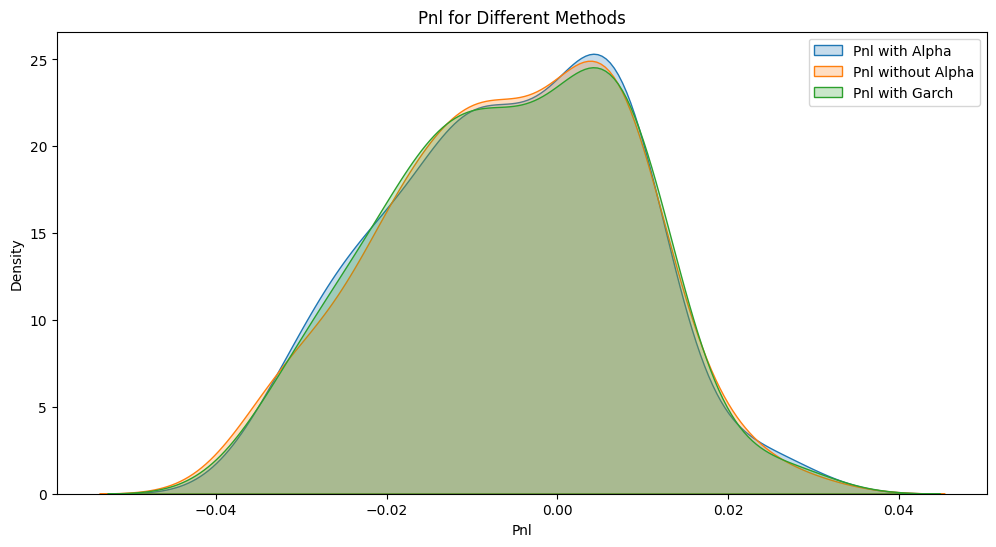

In [107]:
# prompt: plot distribution of pnl_with_alpha and pnl_without_alpha with kernel

import seaborn as sns

# Assuming pnl_with_alpha and pnl_without_alpha are already defined
plt.figure(figsize=(12, 6))
sns.kdeplot(pnl_with_alpha, label='Pnl with Alpha', shade=True)
sns.kdeplot(pnl_without_alpha, label='Pnl without Alpha', shade=True)
sns.kdeplot(pnl_garch, label='Pnl with Garch', shade=True)
plt.xlabel('Pnl')
plt.ylabel('Density')
plt.title('Pnl for Different Methods')
plt.legend()


plt.show()